In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer
from sklearn.utils import shuffle

from tools import plot_confusion_matrix

In [2]:
df = pd.read_csv('../data/datatran_2016-2017.csv', dtype={'br_str': str})
df.shape

/Users/leportella/.virtualenvs/udacity/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,11,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(180991, 32)

In [3]:
df.target.value_counts()

1    106534
0     64166
2     10291
Name: target, dtype: int64

In [4]:
dd = df[['weekday', 'uf', 'br_str', 'km_int', 'accident_cause_simplified', 'accident_type', 
        'moment_of_day', 'climate', 'road_type', 'road_layout', 'road_way', 'target']]
dd = dd.dropna()

In [5]:
dd.shape

(180991, 12)

In [6]:
X = pd.get_dummies(dd.drop(['target'], axis=1))
y = dd['target']

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=200)
X_PCA = pca.fit_transform(X)

In [8]:
model_class0 = joblib.load('../model/model_v10-no-victms.pkl')
model_class1 = joblib.load('../model/model_v10-injuried-victims.pkl')
model_class2 = joblib.load('../model/model_v10-dead-victims.pkl')

In [9]:
y_predict_class0 = model_class0.predict_proba(X_PCA)
y_predict_class1 = model_class1.predict_proba(X_PCA)
y_predict_class2 = model_class2.predict_proba(X_PCA)

df_predict = pd.DataFrame({
    'class_0': y_predict_class0[:,1],
    'class_1': y_predict_class1[:,1],
    'class_2': y_predict_class2[:,1],
})

In [10]:
X_final = pd.concat([df_predict, pd.DataFrame(X_PCA)], axis=1)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

In [12]:
model = LogisticRegression()

parameters = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 0.5, 1., 1.5],
    'class_weight': ['balanced', None]
}


scorer = make_scorer(score_func=accuracy_score)

grid_obj = GridSearchCV(model, parameters, scoring=scorer)

grid_fit = grid_obj.fit(X_train, y_train)

best_clf = grid_fit.best_estimator_

In [13]:
y_pred = best_clf.predict(X_test)

In [14]:
accuracy_score(y_test, y_pred)

0.6307356556810961

Confusion matrix, without normalization
[[ 4621  8273     5]
 [ 3034 18177    34]
 [  172  1849    34]]


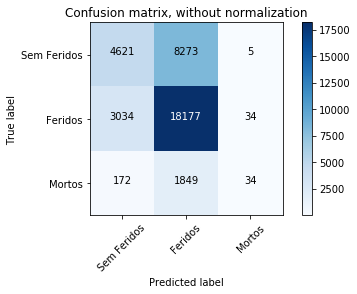

In [15]:
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, classes=['Sem Feridos', 'Feridos', 'Mortos'],
                      title='Confusion matrix, without normalization')

In [16]:
precision0 = cnf_matrix[0,0] / (cnf_matrix[0,0] + cnf_matrix[1,0] + cnf_matrix[1,2])
recall0 = cnf_matrix[0,0] / (cnf_matrix[0,0] + cnf_matrix[0,1] + cnf_matrix[0,2])

print('Precision classe de sem vítimas: ', precision0)
print('Recall classe de sem vítimas: ', recall0)
print('F1 classe de sem vítimas: ', 1 * ((precision0 * recall0) / (precision0 + recall0)))
print('----')

precision1 = cnf_matrix[1,1] / (cnf_matrix[1,1] + cnf_matrix[0,1] + cnf_matrix[2,1])
recall1 = cnf_matrix[1,1] / (cnf_matrix[1,1] + cnf_matrix[1,0] + cnf_matrix[1,2])

print('Precision classe de feridos: ', precision1)
print('Recall classe de feridos: ', recall1)
print('F1 classe de feridos: ', 1 * ((precision1 * recall1) / (precision1 + recall1)))
print('----')

precision2 = cnf_matrix[2,2] / (cnf_matrix[2,2] + cnf_matrix[0,2] + cnf_matrix[1,2])
recall2 = cnf_matrix[2,2] / (cnf_matrix[2,2] + cnf_matrix[2,0] + cnf_matrix[2,1])

print('Precision classe de mortos: ', precision2)
print('Recall classe de mortos: ', recall2)
print('F1 classe de mortos: ', 1 * ((precision2 * recall2) / (precision2 + recall2)))

Precision classe de sem vítimas:  0.6009884250227597
Recall classe de sem vítimas:  0.35824482518024653
F1 classe de sem vítimas:  0.22445113658441807
----
Precision classe de feridos:  0.6423195165906922
Recall classe de feridos:  0.8555895504824664
F1 classe de feridos:  0.36688600032294527
----
Precision classe de mortos:  0.4657534246575342
Recall classe de mortos:  0.01654501216545012
F1 classe de mortos:  0.015977443609022556
